In [9]:
import pandas as pd
import numpy as np
import warnings
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
from rdkit import RDLogger

# ============================
# 0. CONFIGURATION
# ============================
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

# ============================
# 1. LOAD DATA
# ============================
try:
    df = pd.read_csv('../data/clintox.csv')
    print(f"Dataset loaded: {len(df)} compounds.")
except FileNotFoundError:
    print("Error: 'clintox.csv' not found. Using dummy data.")
    df = pd.DataFrame({'SMILES': ['C']*50, 'CT_TOX': [0]*45 + [1]*5})

# ============================
# 2. DEFINE FUNCTIONS (Features and Fingerprints)
# ============================

def calculate_lipinski_and_counts(smiles):
    """Calculate scalar properties (MW, LogP, atom counts)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    
    feats = {
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol)
    }
    
    # Extra counts (useful for analysis)
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    feats['Num_C'] = atoms.count('C')
    feats['Num_Halogens'] = sum([atoms.count(x) for x in ['F', 'Cl', 'Br', 'I']])
    feats['Total_Formal_Charge'] = Chem.GetFormalCharge(mol)
    
    return feats

def get_fingerprints(smiles, n_bits=1024):
    """Generate Morgan Fingerprints (ECFP4) as a list of 0s and 1s."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return [0] * n_bits
    
    # Radius 2 = ECFP4
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    return list(fp)

# ============================
# 3. PROCESS DATASET
# ============================
processed_data = []

print("Processing compounds (Lipinski + Fingerprints)...")

for idx, row in df.iterrows():
    smiles = row['SMILES']
    
    # 1. Calculate scalar features
    scalar_feats = calculate_lipinski_and_counts(smiles)
    
    if scalar_feats:
        # 2. Calculate Fingerprints (optional: 1024 bits to avoid huge CSV)
        fp_bits = get_fingerprints(smiles, n_bits=1024)
        
        # 3. Build dictionary for this row
        new_row = row.to_dict()
        new_row.update(scalar_feats)
        
        # Add fingerprint bits as columns FP_0, FP_1, ...
        for i, bit in enumerate(fp_bits):
            new_row[f'FP_{i}'] = bit
            
        processed_data.append(new_row)

df_full = pd.DataFrame(processed_data)
print(f"Valid compounds: {len(df_full)}")

# ============================
# 4. SCAFFOLD SPLIT
# ============================
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold, isomericSmiles=False)
    except:
        return smiles

print("Performing Scaffold Split...")
scaffold_groups = defaultdict(list)
for idx, smiles in enumerate(df_full['SMILES']):
    scaf = get_scaffold(smiles)
    scaffold_groups[scaf].append(idx)

scaffolds = list(scaffold_groups.keys())
train_scaf, test_val_scaf = train_test_split(scaffolds, test_size=0.2, random_state=42)
valid_scaf, test_scaf = train_test_split(test_val_scaf, test_size=0.5, random_state=42)

def get_idx(scaf_list):
    indices = []
    for s in scaf_list:
        indices.extend(scaffold_groups[s])
    return indices

train_df = df_full.iloc[get_idx(train_scaf)]
valid_df = df_full.iloc[get_idx(valid_scaf)]
test_df  = df_full.iloc[get_idx(test_scaf)]

# ============================
# 5. SAVE DATA
# ============================
# All columns, including SMILES, Lipinski properties, and fingerprints
train_df.to_csv('train_augmented.csv', index=False)
valid_df.to_csv('valid_augmented.csv', index=False)
test_df.to_csv('test_augmented.csv', index=False)

print("\nFiles generated successfully (including SMILES, Lipinski, and Fingerprints):")
print(f"- Train: {len(train_df)} rows")
print(f"- Valid: {len(valid_df)} rows")
print(f"- Test:  {len(test_df)} rows")


Dataset loaded: 1477 compounds.
Processing compounds (Lipinski + Fingerprints)...
Valid compounds: 1477
Performing Scaffold Split...
Valid compounds: 1477
Performing Scaffold Split...

Files generated successfully (including SMILES, Lipinski, and Fingerprints):
- Train: 1257 rows
- Valid: 114 rows
- Test:  106 rows

Files generated successfully (including SMILES, Lipinski, and Fingerprints):
- Train: 1257 rows
- Valid: 114 rows
- Test:  106 rows


In [11]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, average_precision_score
import pandas as pd
import numpy as np
from rdkit import Chem

# ============================
# CONFIGURATION
# ============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# ============================
# 1. DETAILED FEATURIZATION
# ============================
def get_atom_features(atom):
    # a. Atomic number (One-Hot)
    permitted_atoms = [6, 7, 8, 9, 15, 16, 17, 35, 53]  # C,N,O,F,P,S,Cl,Br,I
    atom_type = [int(atom.GetAtomicNum() == x) for x in permitted_atoms]
    atom_type.append(1 if sum(atom_type) == 0 else 0)  # 'Other'
    
    # b. Chirality (Binary: has chiral center or not)
    has_chirality = 1 if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED else 0
    
    # c. Degree (One-Hot 0-5)
    degree = atom.GetDegree()
    degree_enc = [int(degree == x) for x in range(6)]
    
    # d. Hybridization (SP, SP2, SP3)
    hyb = atom.GetHybridization()
    hyb_enc = [
        int(hyb == Chem.rdchem.HybridizationType.SP),
        int(hyb == Chem.rdchem.HybridizationType.SP2),
        int(hyb == Chem.rdchem.HybridizationType.SP3)
    ]
    hyb_enc.append(1 if sum(hyb_enc) == 0 else 0)  # 'Other' hybridization
    
    # e. Aromaticity (Binary)
    is_aromatic = 1 if atom.GetIsAromatic() else 0
    
    # f. Formal charge
    formal_charge = atom.GetFormalCharge()
    
    # Concatenate all
    return torch.tensor(atom_type + [has_chirality] + degree_enc + hyb_enc + [is_aromatic] + [formal_charge], dtype=torch.float)

def smiles_to_graph(row):
    mol = Chem.MolFromSmiles(row['SMILES'])
    if mol is None: return None
    
    # Nodes
    x = torch.stack([get_atom_features(a) for a in mol.GetAtoms()])
    
    # Edges
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices.append((i, j))
        edge_indices.append((j, i))
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices else torch.empty((2,0), dtype=torch.long)
    
    # Global features (Lipinski from CSV)
    global_feats = torch.tensor([
        row['MW'], row['LogP'], row['NumHDonors'], row['NumHAcceptors'], row['TPSA']
    ], dtype=torch.float).view(1,-1)
    
    y = torch.tensor([row['CT_TOX']], dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, global_attr=global_feats, y=y)

# ============================
# 2. DATA LOADING & SAMPLER (Imbalance Handling)
# ============================
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    # Normalize global columns (important for neural networks)
    cols_to_norm = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
    for col in cols_to_norm:
        df[col] = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
        
    data_list = [smiles_to_graph(row) for _, row in df.iterrows() if smiles_to_graph(row)]
    return data_list

print("Loading graphs...")
train_data = load_data('train_augmented.csv')
valid_data = load_data('valid_augmented.csv')
test_data  = load_data('test_augmented.csv')

# --- STRATEGY 1: WeightedRandomSampler ---
y_train = [d.y.item() for d in train_data]
class_counts = np.bincount([int(y) for y in y_train])
class_weights = 1. / class_counts
sample_weights = [class_weights[int(y)] for y in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

# --- STRATEGY 2: Weighted Loss ---
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
pos_weight = torch.tensor([num_neg / num_pos], device=device)

# ============================
# 3. GNN MODEL (GIN)
# ============================
class GNN(torch.nn.Module):
    def __init__(self, node_dim, global_dim, hidden=64):
        super().__init__()
        # Graph branch
        self.conv1 = GINConv(Sequential(Linear(node_dim, hidden), ReLU(), Linear(hidden, hidden), BatchNorm1d(hidden)))
        self.conv2 = GINConv(Sequential(Linear(hidden, hidden), ReLU(), Linear(hidden, hidden), BatchNorm1d(hidden)))
        self.conv3 = GINConv(Sequential(Linear(hidden, hidden), ReLU(), Linear(hidden, hidden), BatchNorm1d(hidden)))
        
        # Global branch
        self.global_mlp = Sequential(Linear(global_dim, hidden), ReLU(), Linear(hidden, hidden))
        
        # Fusion
        self.head = Sequential(
            Linear(hidden*2, hidden), ReLU(), Dropout(0.5),
            Linear(hidden, 1)
        )
        
    def forward(self, x, edge_index, batch, global_attr):
        # Graph
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_add_pool(x, batch)
        
        # Global
        g = self.global_mlp(global_attr)
        
        # Concatenate
        out = torch.cat([x, g], dim=1)
        return self.head(out)

# Initialize
node_features_dim = train_data[0].x.shape[1]
global_features_dim = 5  # Lipinski features
model = GNN(node_features_dim, global_features_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ============================
# 4. TRAINING
# ============================
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.global_attr)
        loss = criterion(out, data.y.view(-1,1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# ============================
# EVALUATION FUNCTION
# ============================
def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.global_attr)
            loss = criterion(out, data.y.view(-1,1))
            total_loss += loss.item() * data.num_graphs
            probs = torch.sigmoid(out)
            preds.extend(probs.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
            
    avg_loss = total_loss / len(loader.dataset)
    
    try:
        roc_auc = roc_auc_score(targets, preds)
        pr_auc = average_precision_score(targets, preds)
    except ValueError:
        roc_auc = 0.5
        pr_auc = 0.0
        
    binary_preds = [1 if p>0.5 else 0 for p in preds]
    return avg_loss, roc_auc, pr_auc, binary_preds, targets

# ============================
# EARLY STOPPING CONFIG
# ============================
patience = 15
min_delta = 0.0001
best_val_loss = float('inf')
counter = 0

print(f"Training model with Early Stopping (Patience: {patience})...")

for epoch in range(1,201):
    train_loss = train()
    val_loss, val_roc, val_pr, _, _ = evaluate(valid_loader)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PR-AUC: {val_pr:.4f}")
    
    if val_loss < (best_val_loss - min_delta):
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f"   > No improvement ({counter}/{patience})")
        
    if counter >= patience:
        print(f"\n⏹ Early Stopping triggered at epoch {epoch-patience}.")
        break

# ============================
# LOAD BEST MODEL & EVALUATE TEST SET
# ============================
print("\nLoading best saved model for final evaluation...")
model.load_state_dict(torch.load('best_model.pth'))

print("\n--- Final Test Set Results ---")
test_loss, test_roc, test_pr, test_pred, test_target = evaluate(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"ROC-AUC:   {test_roc:.4f}")
print(f"PR-AUC:    {test_pr:.4f}")
print("\nClassification Report:")
print(classification_report(test_target, test_pred, target_names=['Safe', 'Toxic']))

# ----------------------------
# SAVE MODEL + METADATA
# ----------------------------
import os, json, datetime, shutil

# Ensure Models dir exists (notebook runs from `src/` so this creates `src/Models`)
os.makedirs('Models', exist_ok=True)

# Save the entire model object as a pickle (.pkl)
try:
    torch.save(model, 'Models/gin_model.pkl')
    print("Saved full model to 'Models/gin_model.pkl'")
except Exception as e:
    print("Warning: Could not save full model object (torch.save).", e)

# Copy the best state_dict file into Models as well
try:
    shutil.copy('best_model.pth', 'Models/gin_model_state_dict.pth')
    print("Copied state_dict to 'Models/gin_model_state_dict.pth'")
except Exception as e:
    print("Warning: Could not copy state_dict file.", e)

# Prepare metadata with basic info and final test metrics
try:
    saved_at = datetime.datetime.utcnow().isoformat() + 'Z'
except Exception:
    saved_at = None

metadata = {
    'model_name': 'GIN',
    'saved_at_utc': saved_at,
    'node_features_dim': int(node_features_dim) if 'node_features_dim' in globals() else None,
    'global_features_dim': int(global_features_dim) if 'global_features_dim' in globals() else None,
    'device': str(device),
    'test_metrics': {
        'test_loss': float(test_loss) if 'test_loss' in globals() else None,
        'roc_auc': float(test_roc) if 'test_roc' in globals() else None,
        'pr_auc': float(test_pr) if 'test_pr' in globals() else None
    },
    'notes': 'Saved full model via torch.save (pickle) and copied state_dict.'
}

# Write metadata.json
try:
    with open('Models/metadata.json', 'w') as mf:
        json.dump(metadata, mf, indent=2)
    print("Saved metadata to 'Models/metadata.json'")
except Exception as e:
    print("Warning: Could not write metadata.json.", e)


Loading graphs...
Training model with Early Stopping (Patience: 15)...
Training model with Early Stopping (Patience: 15)...
Epoch 001 | Train Loss: 4.3514 | Val Loss: 4.1634 | Val PR-AUC: 0.2313
Epoch 002 | Train Loss: 2.2939 | Val Loss: 2.9428 | Val PR-AUC: 0.2745
Epoch 001 | Train Loss: 4.3514 | Val Loss: 4.1634 | Val PR-AUC: 0.2313
Epoch 002 | Train Loss: 2.2939 | Val Loss: 2.9428 | Val PR-AUC: 0.2745
Epoch 003 | Train Loss: 1.6788 | Val Loss: 2.7473 | Val PR-AUC: 0.3108
Epoch 004 | Train Loss: 1.3604 | Val Loss: 1.9268 | Val PR-AUC: 0.3750
Epoch 003 | Train Loss: 1.6788 | Val Loss: 2.7473 | Val PR-AUC: 0.3108
Epoch 004 | Train Loss: 1.3604 | Val Loss: 1.9268 | Val PR-AUC: 0.3750
Epoch 005 | Train Loss: 1.1561 | Val Loss: 1.5105 | Val PR-AUC: 0.4454
Epoch 006 | Train Loss: 0.9162 | Val Loss: 1.5682 | Val PR-AUC: 0.4364
   > No improvement (1/15)
Epoch 005 | Train Loss: 1.1561 | Val Loss: 1.5105 | Val PR-AUC: 0.4454
Epoch 006 | Train Loss: 0.9162 | Val Loss: 1.5682 | Val PR-AUC: 0.43


Confusion Matrix (raw):
[[58 34]
 [ 1 13]]

Confusion Matrix (table format):
              Pred Safe  Pred Toxic
Actual Safe          58          34
Actual Toxic          1          13


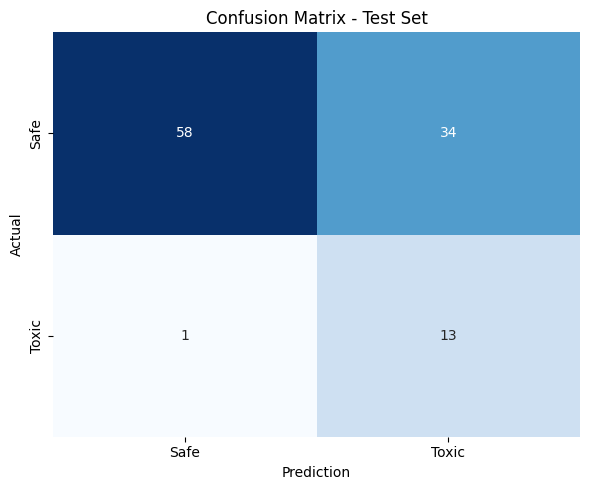

In [17]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_target, test_pred)

print("\nConfusion Matrix (raw):")
print(cm)

# Optional: display as a clearer DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['Actual Safe', 'Actual Toxic'],
    columns=['Pred Safe', 'Pred Toxic']
)

print("\nConfusion Matrix (table format):")
print(cm_df)

# ----------------------------
# Seaborn heatmap
# ----------------------------
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Safe', 'Toxic'],
    yticklabels=['Safe', 'Toxic'],
    cbar=False
)

plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()

plt.savefig('gin_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


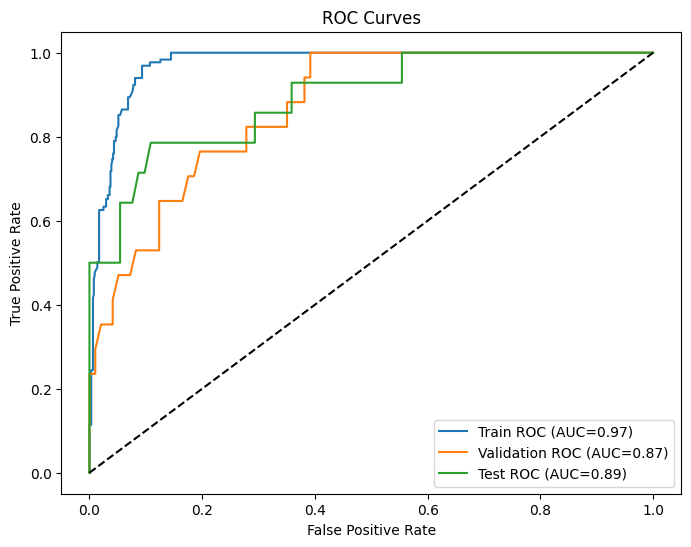

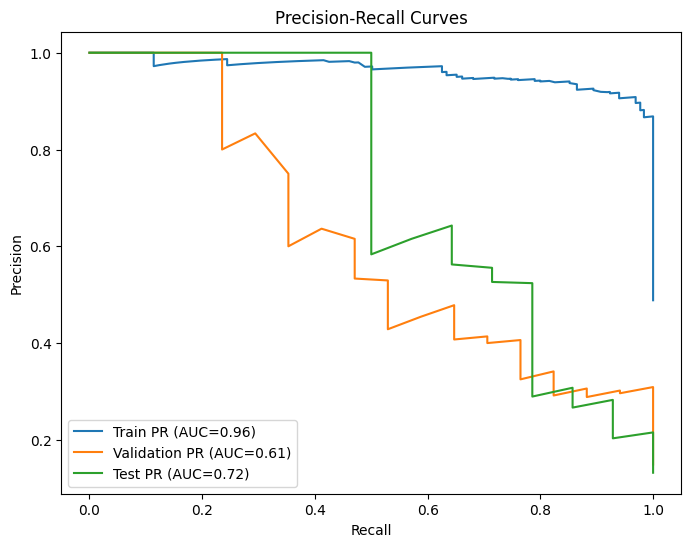

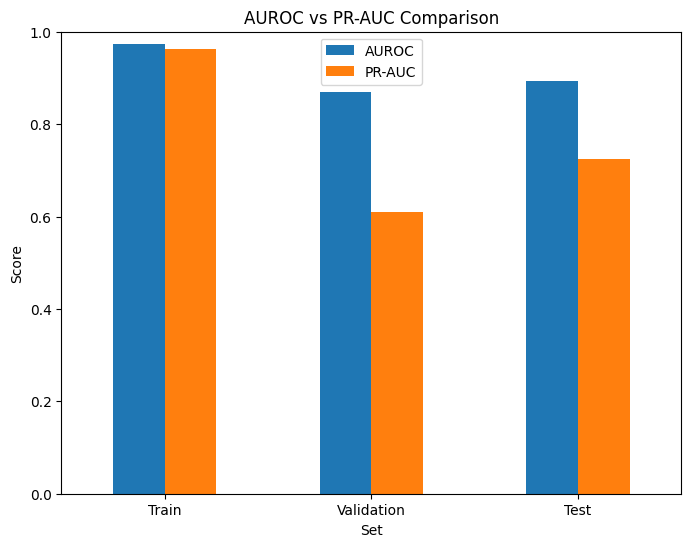

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd
import numpy as np

# ==========================================
# 1. Get predictions and targets
# ==========================================
def get_preds_and_targets(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.global_attr)
            probs = torch.sigmoid(out)
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(data.y.cpu().numpy())
    return np.array(all_targets), np.array(all_preds)

# Train, Validation, Test
y_train, p_train = get_preds_and_targets(train_loader)
y_val, p_val     = get_preds_and_targets(valid_loader)
y_test, p_test   = get_preds_and_targets(test_loader)

# ==========================================
# 2. ROC Curves
# ==========================================
plt.figure(figsize=(8,6))

fpr_train, tpr_train, _ = roc_curve(y_train, p_train)
fpr_val, tpr_val, _     = roc_curve(y_val, p_val)
fpr_test, tpr_test, _   = roc_curve(y_test, p_test)

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)

plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC={auc_train:.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC={auc_val:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={auc_test:.2f})')

plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.savefig('gin_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. Precision-Recall Curves
# ==========================================
plt.figure(figsize=(8,6))

precision_train, recall_train, _ = precision_recall_curve(y_train, p_train)
precision_val, recall_val, _     = precision_recall_curve(y_val, p_val)
precision_test, recall_test, _   = precision_recall_curve(y_test, p_test)

pr_auc_train = average_precision_score(y_train, p_train)
pr_auc_val   = average_precision_score(y_val, p_val)
pr_auc_test  = average_precision_score(y_test, p_test)

plt.plot(recall_train, precision_train, label=f'Train PR (AUC={pr_auc_train:.2f})')
plt.plot(recall_val, precision_val, label=f'Validation PR (AUC={pr_auc_val:.2f})')
plt.plot(recall_test, precision_test, label=f'Test PR (AUC={pr_auc_test:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.savefig('gin_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. Comparative Histogram of AUROC and PR-AUC
# ==========================================
metrics = pd.DataFrame({
    'Set': ['Train','Validation','Test'],
    'AUROC': [auc_train, auc_val, auc_test],
    'PR-AUC': [pr_auc_train, pr_auc_val, pr_auc_test]
})

metrics.plot(x='Set', y=['AUROC','PR-AUC'], kind='bar', figsize=(8,6))
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.title("AUROC vs PR-AUC Comparison")
plt.ylabel("Score")
plt.savefig('gin_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
